In [ ]:
import os
import sys
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/My Drive/Colab Notebooks")

In [ ]:
!pip3 install pyro-ppl

     |████████████████████████████████| 678 kB 5.1 MB/s 


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as LR

In [ ]:
import os
import sys
from google.colab import drive
import statistics

In [ ]:
import numpy as np

import scipy.stats
from scipy.stats import norm

from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize

%matplotlib inline
import torch
from torch.distributions import constraints

import pyro
import pyro.infer
import pyro.optim as optim
import pyro.distributions as dist

pyro.set_rng_seed(101)
torch.manual_seed(101)
np.random.seed(12);

In [ ]:
df=pd.read_csv('Book 4.csv',header=None)
# df_test=pd.read_csv('https://s3.amazonaws.com/istreet-questions-us-east-1/418844/test.csv',header=None)

df.head()

,0,1
0,5.977789,4.980777


In [ ]:
velocity,yaw,ang_vel=[],[],[]
count=0
for i in range(1,11):
  count+=1
  # print(count)
  f=open("{}.txt".format(i),"r")
  yawl,avel,vx,vy=[],[],[],[]
  for line in f:
    # print(line)
    
    ls=line.split(" ")
    if ls[-1][:-1]=="\n":
      ls[-1]=ls[-1][:-1]
    ls=list(map(float,ls))
    
    vx.append(ls[0])
    vy.append(ls[1])
    yawl.append(ls[2])
    avel.append(ls[3])
    # print(ls)
  f.close()
  yaw.append(statistics.mean(yawl))
  ang_vel.append(statistics.mean(avel))
  x=statistics.mean(vx)
  y=statistics.mean(vy)
  velocity.append(((x**2)+(y**2))**(0.5))




In [ ]:
velocity=np.array(velocity)
yaw=np.array(yaw)
ang_vel=np.array(ang_vel)

In [ ]:
velocity

array([13.91424185,  3.35383366, 11.03455584,  9.43727602,  5.03286097,
        4.05553597, 21.94238155,  7.0112914 ,  5.92875802, 15.59002858])

In [ ]:
print(velocity.mean(),yaw.mean(),ang_vel.mean())

9.73007638647328 -5.899132649522689 172.8428850246266


In [ ]:
print(velocity.std(),yaw.std(),ang_vel.std())

5.652756871484022 28.532955224439853 161.22335857571576


In [ ]:

x=torch.tensor(ang_vel)

In [ ]:
n = 1000
x = np.random.randn(n,1)
std = 4
mu = 2
x = x * std + mu

print(f"Shape: {x.shape}")
print(f"Mean: {np.mean(x)}")
print(f"Standard deviation: {np.std(x)}")

Shape: (1000, 1)
Mean: 1.7653922255563976
Standard deviation: 3.870407390270422


In [ ]:
x=x.reshape(n)
x=torch.tensor(x)

In [ ]:
pyro.distributions.enable_validation(False)

In [ ]:
def data_model(params):
  mu_dist = pyro.sample("mu_dist", dist.Normal(torch.tensor(params[0]), torch.tensor(params[1])))
  std_dist = pyro.sample(
      "std_dist", dist.Gamma(torch.tensor(np.abs(params[2])), torch.tensor(np.abs(params[3])))
  )
  # with pyro.plate("observed_data", size=len(X)):
  #       sample = pyro.sample("gaussian_data", dist.Normal(mu, 1/torch.sqrt(tau)), obs=X)
  # print("no")
  # print(mu_dist,std_dist)
  sample=0
  with pyro.plate("observation_dist",size=len(x)):
    sample=pyro.sample("data_dist",dist.Normal(mu_dist, std_dist),obs=x)
  return sample


# conditioned_data_model = pyro.condition(
#     data_model, data={"data_dist": torch.tensor(x.flatten())}
# )

In [ ]:
def parametrised_guide(params):
  mu_mu = pyro.param("mu_mu", torch.tensor(params[0]))
  mu_std = pyro.param(
      "mu_std", torch.tensor(params[1]), constraint=constraints.positive
  )
  std_a = pyro.param(
      "std_a", torch.tensor(params[2]), constraint=constraints.positive
  )
  std_b = pyro.param(
      "std_b", torch.tensor(params[3]), constraint=constraints.positive
  )

  mu_dist = pyro.sample("mu_dist", dist.Normal(mu_mu, mu_std))
  std_dist = pyro.sample("std_dist", dist.Gamma(std_a, std_b))
  # print("yes")
  # print(mu_dist,std_dist)
  
  return pyro.sample("data_dist", dist.Normal(mu_dist, std_dist))

In [ ]:
adam_params = {"lr": 0.3, "betas": (0.95, 0.999)}

# pyro.optim.SGD({"lr": 0.0001, "momentum": 0.9})
optimizer = pyro.optim.Adam(adam_params)
svi = pyro.infer.SVI(
  model=data_model,
  guide=parametrised_guide,
  optim=optimizer,
  loss=pyro.infer.Trace_ELBO(),
)

In [ ]:
mu_prior = [-10.0, 10.0]  # Gaussian - mu, std
std_prior = [1.0, 0.1]  # Gamma - a, b
params_prior = mu_prior + std_prior

print(params_prior)

# params_prior=torch.tensor(params_prior)
print(params_prior)
# Iterate over all the data
losses, mu_mu, mu_std, std_a, std_b = [], [], [], [], []
pyro.clear_param_store()

[-10.0, 10.0, 1.0, 0.1]
[-10.0, 10.0, 1.0, 0.1]


In [ ]:

num_steps = 5000
for t in range(num_steps):
  loss=svi.step(params_prior)
  losses.append(loss)
  mu_mu.append(pyro.param("mu_mu").item())
  mu_std.append(pyro.param("mu_std").item())
  std_a.append(pyro.param("std_a").item())
  std_b.append(pyro.param("std_b").item())
  if (t%100==0):
    print("{}  {}".format(t,loss))

/usr/local/lib/python3.7/dist-packages/pyro/util.py:289: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'data_dist'}
  guide_vars - aux_vars - model_vars


0  87565.3575303906
100  6295.130991785729
200  4600.1443165684905
300  3388.1730718709873
400  2843.6628065616937
500  2896.3431186051685
600  3147.556841275876
700  2788.957514307856
800  3063.217989595021
900  2853.4152072878514
1000  3019.8210075749644
1100  2828.064459217951
1200  2790.119105052184
1300  2841.7783410121083
1400  2779.505261933255
1500  2799.1913037985064
1600  2781.6502296776057
1700  2815.3325907740023
1800  2777.9286776921354
1900  2827.2753288246877
2000  2825.8991496188587
2100  2788.9978742899298
2200  2783.062692399181
2300  2801.9342895951445
2400  2792.180235613628
2500  2777.6001818848545
2600  2793.498725032962
2700  2801.2106001576403
2800  2781.606538094413
2900  2798.139235065619
3000  2816.378121620095
3100  2805.3403239095996
3200  2791.9965000113534
3300  2777.384627123302
3400  2790.255311975389
3500  2778.173912602449
3600  2834.0052088783964
3700  2782.353702659268
3800  2778.451150139418
3900  2783.1218641245523
4000  2784.2693259797497
4100  2

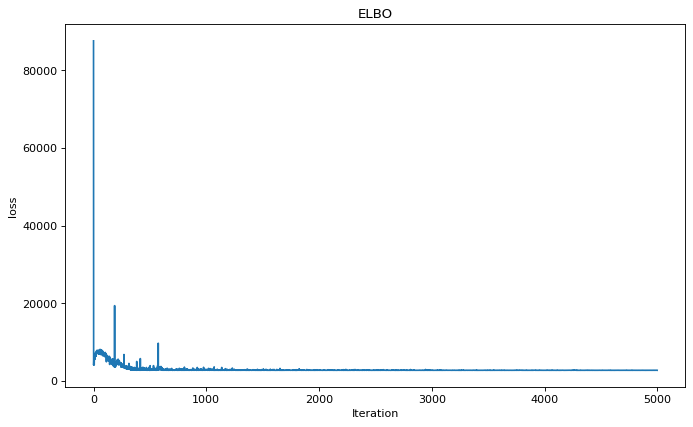

In [ ]:
# Convergence of the loss function
plt.figure(num=None, figsize=(10, 6), dpi=80)
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("Iteration")
plt.ylabel("loss")
# plt.savefig("images/elbo.png")
plt.show()

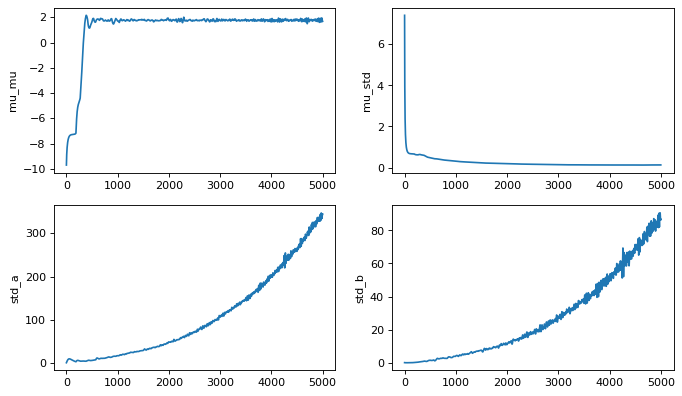

In [ ]:
plt.figure(num=None, figsize=(10, 6), dpi=80)
plt.subplot(2, 2, 1)
plt.plot(mu_mu)
plt.ylabel("mu_mu")

plt.subplot(2, 2, 2)
plt.ylabel("mu_std")
plt.plot(mu_std)

plt.subplot(2, 2, 3)
plt.ylabel("std_a")
plt.plot(std_a)

plt.subplot(2, 2, 4)
plt.ylabel("std_b")
plt.plot(std_b)
# plt.savefig("images/params.png")
plt.show()

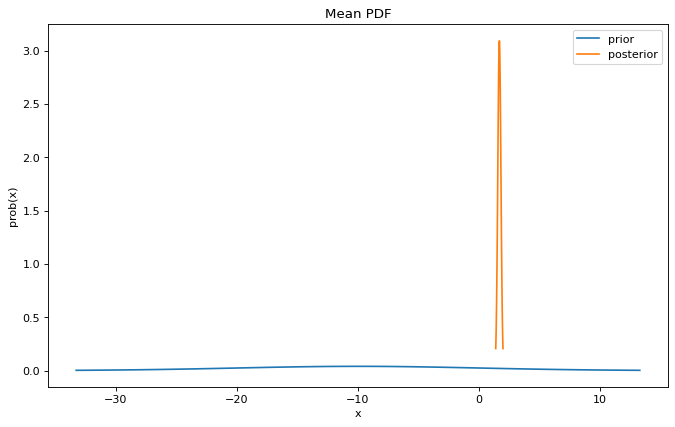

In [ ]:
# Plot mean distributions
plt.figure(num=None, figsize=(10, 6), dpi=80)
mu_prior_dist = norm(loc=mu_prior[0], scale=mu_prior[1])
x_range = np.linspace(mu_prior_dist.ppf(0.01), mu_prior_dist.ppf(0.99), num=100)
y_values = mu_prior_dist.pdf(x_range)
plt.plot(x_range, y_values, label="prior")

mu_post_dist = norm(loc=mu_mu[-1], scale=mu_std[-1])
x_range = np.linspace(mu_post_dist.ppf(0.01), mu_post_dist.ppf(0.99), num=100)
y_values = mu_post_dist.pdf(x_range)
plt.plot(x_range, y_values, label="posterior")

plt.xlabel("x")
plt.ylabel("prob(x)")
plt.title("Mean PDF")
plt.legend()
# plt.savefig("images/mean_dist.png")
plt.show()

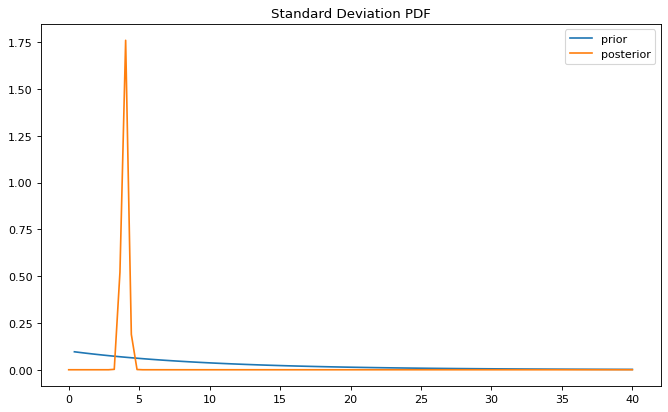

In [ ]:
# Plot std distributions
plt.figure(num=None, figsize=(10, 6), dpi=80)
x_range = np.linspace(0, 40, num=100)

std_prior_dist = dist.Gamma(std_prior[0], std_prior[1])
y_values = torch.exp(std_prior_dist.log_prob(x_range))
plt.plot(x_range, y_values, label="prior")

std_post_dist = dist.Gamma(std_a[-1], std_b[-1])
y_values = torch.exp(std_post_dist.log_prob(x_range))
plt.plot(x_range, y_values, label="posterior")

plt.title("Standard Deviation PDF")
plt.legend()
# plt.savefig("images/std_dist.png")
plt.show()